# **Step 1 – Full Score Extraction (UCF-Crime, C2FPL)**  

Loads the pre-trained C2FPL anomaly detector, processes all pre-extracted clip-level features from the UCF-Crime dataset, and generates frame-level anomaly scores for each video. The results are stored in a nested list (`all_scores`) and flattened into a backup list (`flat_scores`) for later use.


In [35]:
import os
import torch
import numpy as np
import pandas as pd
from typing import List
from model import C2FPL_Detector, TrasnLowNET_classifier

FEATURE_SIZE: int = 512
CLIP_SIZE: int = 16

MODEL_WEIGHTS_PATH: str = "./weightsV1/detector_UniFormer-S_C2fpl_0.82.pkl"
GT_DATABASE: str = "./resources/Temporal_Anomaly_Annotation.txt"
FEATURES_TEMPLATE: str = ("./preprocessedFeatures/UniFormer-S/test/{name}-Uniformer_Small16x8_T_Viariable_Padding.npy")  # Feature path at preprocessed clip level


def load_model(device: torch.device) -> torch.nn.Module:
    """Create the C2FPL model and load its pretrained weights."""
    model = C2FPL_Detector(FEATURE_SIZE).to(device)
    state_dict = torch.load(MODEL_WEIGHTS_PATH, weights_only=True)
    state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
    model.load_state_dict(state_dict)
    return model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Working directory: {os.getcwd()}")

model = load_model(device)
model.eval()

# Load ground truth video list
df = pd.read_csv(GT_DATABASE, sep=r"\s+", header=None).values

all_scores: List[List[float]] = []

for video_info in df:
    video_name = video_info[0][:-4]  # Remove extension
    feature_path = FEATURES_TEMPLATE.format(name=video_name)

    clips = np.load(feature_path)
    clips = np.transpose(clips, (1, 0, 2))
    clips_tensor = torch.from_numpy(clips).to(device)

    with torch.no_grad():
        logits = model(inputs=clips_tensor)
    probs = logits.detach().cpu().numpy().flatten().tolist()

    print(video_name, clips_tensor.shape, len(probs))
    all_scores.append(probs)

# Backup: flatten all scores into a single list to preserve original data
flat_scores = [value for sublist in all_scores for value in sublist]
print(f"Total scores collected: {len(flat_scores)}")


Working directory: /media/pc/mainWork1/Tensin/CodesShare/TransLowNet
Abuse028_x264 torch.Size([89, 10, 512]) 89
Abuse030_x264 torch.Size([97, 10, 512]) 97
Arrest001_x264 torch.Size([149, 10, 512]) 149
Arrest007_x264 torch.Size([197, 10, 512]) 197
Arrest024_x264 torch.Size([227, 10, 512]) 227
Arrest030_x264 torch.Size([541, 10, 512]) 541
Arrest039_x264 torch.Size([990, 10, 512]) 990
Arson007_x264 torch.Size([391, 10, 512]) 391
Arson009_x264 torch.Size([47, 10, 512]) 47
Arson010_x264 torch.Size([198, 10, 512]) 198
Arson011_x264 torch.Size([80, 10, 512]) 80
Arson016_x264 torch.Size([113, 10, 512]) 113
Arson018_x264 torch.Size([53, 10, 512]) 53
Arson022_x264 torch.Size([540, 10, 512]) 540
Arson035_x264 torch.Size([90, 10, 512]) 90
Arson041_x264 torch.Size([235, 10, 512]) 235
Assault006_x264 torch.Size([506, 10, 512]) 506
Assault010_x264 torch.Size([1012, 10, 512]) 1012
Assault011_x264 torch.Size([143, 10, 512]) 143
Burglary005_x264 torch.Size([484, 10, 512]) 484
Burglary017_x264 torch.Size

# **Step 2 – AUC on Full Test Set (Frame-Level)**  
Builds frame-level ground truth from temporal annotations, expands clip scores to frame-level, and computes the ROC curve and AUC over the entire test set. Outputs FPR/TPR arrays and the threshold vector used for later.


In [36]:
from sklearn.metrics import auc, roc_curve
from collections import Counter


# Load GT database
df = pd.read_csv(GT_DATABASE, sep=r"\s+", header=None).values
print(f"Working directory: {os.getcwd()}")
gtFullInferenceFrameLevel = []

for nameVideo_Test in df:
    nameVideoTest = nameVideo_Test[0][:-4]
    nameVideoFeatures = f"./preprocessedFeatures/UniFormer-S/sizeFeatures/{nameVideoTest}.mp4.npy"
    videoAllClips = np.load(nameVideoFeatures)
    sizeVideoFrame = videoAllClips.shape[0] * CLIP_SIZE

    anomali_1 = [nameVideo_Test[2], nameVideo_Test[3]]
    anomali_2 = [nameVideo_Test[4], nameVideo_Test[5]]

    gtListFrames = [0] * sizeVideoFrame

    # Mark first anomaly
    for indexAbnormal in range(anomali_1[0], anomali_1[1]):
        gtListFrames[indexAbnormal] = 1

    # Mark second anomaly if valid
    if anomali_2[1] + anomali_2[1] != -2:
        for indexAbnormal in range(anomali_2[0], anomali_2[1]):
            gtListFrames[indexAbnormal] = 1

    gtFullInferenceFrameLevel.append(gtListFrames)

# Flatten GT list
gtFullInferenceFrameLevel = [
    valor for sublista in gtFullInferenceFrameLevel for valor in sublista
]

# Expand scores to frame-level
scorePred_Framelabel = [x for x in flat_scores for _ in range(CLIP_SIZE)]

# Ensure lengths match
assert len(gtFullInferenceFrameLevel) == len(scorePred_Framelabel)

# ROC & AUC computation
fpr, tpr, threshold = roc_curve(gtFullInferenceFrameLevel, scorePred_Framelabel)
rec_auc = auc(fpr, tpr)
print(f"auc: {rec_auc}", len(threshold), len(scorePred_Framelabel))

print(len(threshold), threshold[:10])




Working directory: /media/pc/mainWork1/Tensin/CodesShare/TransLowNet
auc: 0.8227857216238071 9054 1114144
9054 [       inf 0.38697985 0.3865467  0.38479972 0.38375345 0.38338545
 0.37948847 0.37911454 0.3720676  0.37132245]


# **Step 3 – ROC Curve Visualization and Midpoint Threshold Selection**  
Generates and plots the ROC curve using frame-level predictions and ground truth, calculates the AUC, and marks the midpoint operating point (50% along the ROC curve). Displays the curve with styling for clarity and outputs the selected threshold value to the console.


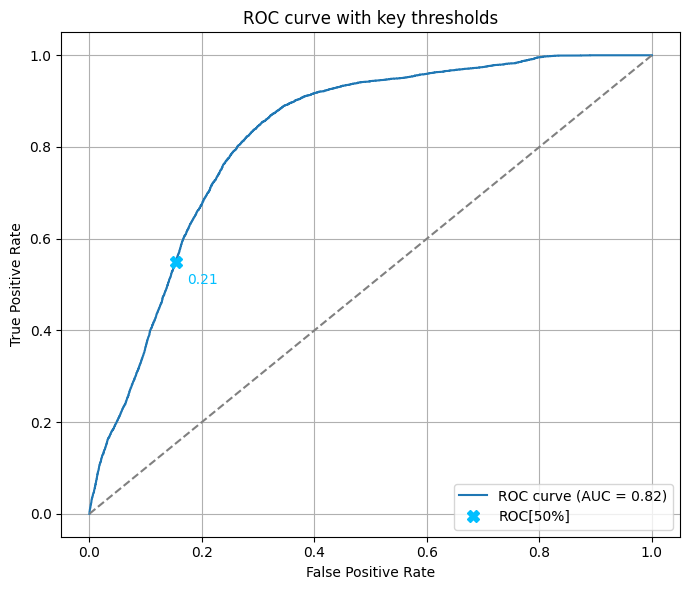


📌 Thresholds marked on the plot:
🔷 ROC[50%]: 0.2117


In [37]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc

# ROC and AUC calculation
fpr, tpr, thresholds = roc_curve(gtFullInferenceFrameLevel, scorePred_Framelabel)
rec_auc = auc(fpr, tpr)
# Append last threshold value to align with fpr/tpr length
thresholds_full = np.append(thresholds, thresholds[-1])

# Midpoint index of the ROC curve
idx_central_roc = len(fpr) // 2

# Plot ROC curve
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {rec_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

# 🔷 Midpoint of the ROC curve
plt.plot(
    fpr[idx_central_roc],
    tpr[idx_central_roc],
    'X',
    color='deepskyblue',
    markersize=9,
    label='ROC[50%]'
)
plt.text(
    fpr[idx_central_roc] + 0.02,
    tpr[idx_central_roc] - 0.05,
    f'{thresholds_full[idx_central_roc]:.2f}',
    color='deepskyblue'
)

# Plot styling
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve with key thresholds')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Console output
print("\n📌 Thresholds marked on the plot:")
print(f"🔷 ROC[50%]: {thresholds_full[idx_central_roc]:.4f}")



# **Step 4 – Final Classification Metrics (Full Test Set)**  
Applies the selected anomaly threshold to gate clip-level classification, runs the TransLowNET classifier on anomalous clips, and computes macro Precision/Recall/F1 and Accuracy at both clip and video levels. Aggregates results over all videos, derives the video-level predicted class (majority over clips), and reports summary statistics along with the confusion matrix and a full classification report.


In [38]:
from sklearn.metrics import (
    auc, roc_curve, confusion_matrix, classification_report,
    precision_score, recall_score, f1_score, accuracy_score
)
from collections import Counter
from statistics import mode
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import torch


# =========================
# Load Ground Truth Database
# =========================
print(f"Working directory: {os.getcwd()}")

gt_Database = './resources/Temporal_Anomaly_Annotation.txt'
df = pd.read_csv(gt_Database, sep=r'\s+', header=None).values


# =========================
# Utility Functions
# =========================

def confusionMat(gt, predictions):
    """Compute confusion matrix and normalized confusion matrix."""
    cm = confusion_matrix(gt, predictions)
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    mean_avg_acc = np.sum(cm.diagonal()) / np.sum(cm)
    mean_avg_acc_norm = np.sum(cmn.diagonal()) / cm.shape[0]
    return cm, cmn, mean_avg_acc, mean_avg_acc_norm


def modelClassification(feature_size, modelWigth_path):
    """Load the classification model."""
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = TrasnLowNET_classifier(feature_size, 13)
    model.load_state_dict({
        k.replace('module.', ''): v
        for k, v in torch.load(modelWigth_path, weights_only=True).items()
    })
    model = model.to(device).eval()
    return model


# =========================
# Model Initialization
# =========================
modelClass_path = "./weightsV1/classifier_UniFormer-S_TransLowNet_0.36.pkl"
classModel = modelClassification(FEATURE_SIZE, modelClass_path)

abnormalClasses = [
    'Abuse', 'Arrest', 'Arson', 'Assault', 'Burglary', 'Explosion',
    'Fighting', 'RoadAccidents', 'Robbery', 'Shooting', 'Shoplifting',
    'Stealing', 'Vandalism', 'Normal'
]

# =========================
# Ground Truth Construction
# =========================
gtClassFull_ClipLevel = []
gtVideoLevel = []

for nameVideo_Test in df:
    current_class = nameVideo_Test[1]
    class_index = abnormalClasses.index(current_class)
    gtVideoLevel.append(class_index)

    nameVideoTest = nameVideo_Test[0][:-4]
    nameVideoFeatures = f"./preprocessedFeatures/UniFormer-S/sizeFeatures/{nameVideoTest}.mp4.npy"
    videoAllClips = np.load(nameVideoFeatures)
    sizeVideoFrame = videoAllClips.shape[0]

    anomali_1 = [nameVideo_Test[2] // 16, nameVideo_Test[3] // 16]
    anomali_2 = [nameVideo_Test[4], nameVideo_Test[5]]

    gtListClips = [13] * sizeVideoFrame

    if current_class == "Normal":
        gtClassFull_ClipLevel.append(gtListClips)
        continue

    for indexAbnormal in range(anomali_1[0], anomali_1[1]):
        gtListClips[indexAbnormal] = class_index

    if anomali_2[1] + anomali_2[1] != -2:
        anomali_2 = [nameVideo_Test[4] // 16, nameVideo_Test[5] // 16]
        for indexAbnormal in range(anomali_2[0], anomali_2[1]):
            gtListClips[indexAbnormal] = class_index

    gtClassFull_ClipLevel.append(gtListClips)

print(len(all_scores), all_scores)
print(len(gtClassFull_ClipLevel), gtClassFull_ClipLevel[60])

for i in range(len(gtClassFull_ClipLevel)):
    assert len(all_scores[i]) == len(gtClassFull_ClipLevel[i])


# =========================
# Evaluation Loop
# =========================
thaout = threshold[idx_central_roc]
fullPrecisionGlobal = []
fullRecallGlobal = []
fullF1Global = []
fullAccuracyGlobal = []
fullPrecisionAnom = []
fullRecallAnom = []
fullF1Anom = []
fullAccuracyAnom = []
fullClassDatabasePred = []
fullThrs = []
fullPredClass = []
fullGtClass = []
fullNames = []

for indexVideo in range(len(all_scores)):
    videoInference = all_scores[indexVideo]  # Raw scores
    gtVideo = gtClassFull_ClipLevel[indexVideo]  # Multi-class GT

    nameVideoTest = df[indexVideo][0][:-4]
    fullNames.append(nameVideoTest)

    clipsInference_1Crop = np.load(f"./preprocessedFeatures/UniFormer-S/test/{nameVideoTest}-Uniformer_Small16x8_T_Viariable_Padding.npy")  # Feature path at preprocessed clip level
    clipsInference_1Crop = clipsInference_1Crop[4]
    sizeVideoClips = clipsInference_1Crop.shape[0]

    assert len(videoInference) == len(gtVideo) == sizeVideoClips

    predVideoFull = []
    for indexClip in range(len(videoInference)):
        if videoInference[indexClip] > thaout:
            with torch.no_grad():
                pred = torch.zeros(0, device=device)
                classModel.eval()
                clipInference = torch.from_numpy(clipsInference_1Crop[indexClip]).to(device)
                logits = classModel(clipInference)
                pred = torch.cat((pred, logits))

            pred = list(pred.cpu().detach().numpy())
            recognition_class = np.argmax(pred, axis=-1)
            predVideoFull.append(recognition_class)
        else:
            predVideoFull.append(13)

    fullGtClass.append(gtVideo)
    fullPredClass.append(predVideoFull)

    justAbnormalClass = [x for x in predVideoFull if x != 13]
    if justAbnormalClass:
        most_common_class = Counter(justAbnormalClass).most_common(1)[0][0]
    else:
        most_common_class = 13

    fullClassDatabasePred.append(most_common_class)

    # Video-level metrics
    precision_global = precision_score(gtVideo, predVideoFull, average='macro', zero_division=0)
    recall_global = recall_score(gtVideo, predVideoFull, average='macro', zero_division=0)
    f1_global = f1_score(gtVideo, predVideoFull, average='macro', zero_division=0)
    accuracy_global = accuracy_score(gtVideo, predVideoFull)

    # Clip-level metrics (only for anomaly clips)
    indices_anomalos = [i for i, x in enumerate(gtVideo) if x != 13]
    gt_anomaly = [gtVideo[i] for i in indices_anomalos]
    pred_anomaly = [predVideoFull[i] for i in indices_anomalos]

    if gt_anomaly:
        precision_anom = precision_score(gt_anomaly, pred_anomaly, average='macro', zero_division=0)
        recall_anom = recall_score(gt_anomaly, pred_anomaly, average='macro', zero_division=0)
        f1_anom = f1_score(gt_anomaly, pred_anomaly, average='macro', zero_division=0)
        accuracy_anom = accuracy_score(gt_anomaly, pred_anomaly)
    else:
        precision_anom = recall_anom = f1_anom = accuracy_anom = 0.0

    fullPrecisionGlobal.append(precision_global)
    fullRecallGlobal.append(recall_global)
    fullF1Global.append(f1_global)
    fullAccuracyGlobal.append(accuracy_global)
    fullPrecisionAnom.append(precision_anom)
    fullRecallAnom.append(recall_anom)
    fullF1Anom.append(f1_anom)
    fullAccuracyAnom.append(accuracy_anom)


# =========================
# Summary Metrics
# =========================
print(f"Full Database, {thaout}")
print("Precision Global: ", (sum(fullPrecisionGlobal) / len(fullPrecisionGlobal)) * 100)
print("Recall Global: ", (sum(fullRecallGlobal) / len(fullRecallGlobal)) * 100)
print("F1 Score Global: ", (sum(fullF1Global) / len(fullF1Global)) * 100)
print("Accuracy Global: ", (sum(fullAccuracyGlobal) / len(fullAccuracyGlobal)) * 100)
print("========================================")


cm, cmn, mean_avg_acc, mean_avg_acc_norm = confusionMat(gtVideoLevel, fullClassDatabasePred)
print("Confusion Matrix: ", mean_avg_acc, mean_avg_acc_norm)
print("Accuracy:", accuracy_score(gtVideoLevel, fullClassDatabasePred) * 100)
print(classification_report(gtVideoLevel, fullClassDatabasePred, digits=4))


Working directory: /media/pc/mainWork1/Tensin/CodesShare/TransLowNet
290 [[0.28940334916114807, 0.2921813428401947, 0.292013943195343, 0.2820992171764374, 0.311646044254303, 0.25887447595596313, 0.2622475326061249, 0.2898305654525757, 0.2719379961490631, 0.31163331866264343, 0.28873181343078613, 0.27870920300483704, 0.28920769691467285, 0.29667016863822937, 0.30842652916908264, 0.25574854016304016, 0.30143973231315613, 0.295560359954834, 0.2678377628326416, 0.30614331364631653, 0.25544556975364685, 0.28401079773902893, 0.2858831584453583, 0.2676805555820465, 0.2936249375343323, 0.2644414007663727, 0.2703340947628021, 0.2882251441478729, 0.25947338342666626, 0.29039692878723145, 0.2770604193210602, 0.26579469442367554, 0.2679813504219055, 0.247314453125, 0.26680681109428406, 0.2506870925426483, 0.2559269964694977, 0.24660101532936096, 0.25097084045410156, 0.25667834281921387, 0.2687661349773407, 0.2780839502811432, 0.26010072231292725, 0.28947389125823975, 0.2561415135860443, 0.26980119

/home/pc/anaconda3/envs/MDPI/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pc/anaconda3/envs/MDPI/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pc/anaconda3/envs/MDPI/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
